# 5. Computer experiments: multistrain communities

In [12]:
import numpy as np
import os
import csv
import sys
import matplotlib.pyplot as plt
import colorcet as cc
import time
import multiprocessing
import random
from tabulate import tabulate
import itertools
import os
import pickle


## File structure

In [13]:
from google.colab import drive
drive.mount('/content/drive')

root='/content/drive/MyDrive/SYNC_Projects/pOXA48/2023/code/py-files/'
os.chdir(root)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
sys.path.insert(0, 'src/')
from pOXA48_S1 import *
from pOXA48_S2 import *
from pOXA48_S3 import *

## Model parameters

In [15]:
%run src/pOXA48_parameters

#Here display experimental parameters

In [16]:

model_params = import_model_params("%smodel_params.csv"%(dataPath), expe_params)
display_model_params_stats(model_params, strains_subset)


╒═════════╤═════════════╤═══════════════════════╤═════════════════════════════════╤═════╕
│ Group   │ Parameter   │ Mean                  │ Range                           │ N   │
╞═════════╪═════════════╪═══════════════════════╪═════════════════════════════════╪═════╡
│ E-TC    │ conj_rate   │ nan                   │ (nan, nan)                      │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ VKm         │ 5.931e-10             │ (3.79e-10, 7.6e-10)             │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ rho         │ 948158352.0           │ (550386500.0, 1121715175.0)     │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    │ seg_rate    │ 0.0020000000000000005 │ (0.002, 0.002)                  │ 10  │
├─────────┼─────────────┼───────────────────────┼─────────────────────────────────┼─────┤
│ E-TC    

## Simulation parameters





In [17]:
num_days = 100
num_expe = 24
iEs = [0]
type_experiment='invasion'

In [18]:
powers = np.arange(-4.0, 2.0)  # array of powers of two exponents
Amax_values=np.power(2.0, powers)  # calculate 2 raised to each exponent
print(Amax_values)

[0.0625 0.125  0.25   0.5    1.     2.    ]


## Computer simulations in stochastic environments

In order to model different environmental regimes and population structures, we performed computer simulations involving numerical solutions of the population dynamics model. We used a dedicated Python package for generating stochastic environments, which accommodates the generation of various stochastic processes such as continuous, discrete, diffusion, and noise methods.

To emulate environments with varying levels of selection pressure, we adjusted a stochastic time series by multiplying it with a constant, $0 \leq A \leq \text{max}(1)$, where this constant signifies the maximum selection pressure exerted by the environment. We performed specific numerical experiments in which the daily drug concentration was established using Gaussian signal noise, characterized by a probability density function equivalent to the normal distribution.

In [19]:
def load_environment(str_E, indx_E, envPath, num_days):
    """
    Loads the environmental data from a specified CSV file.

    Parameters:
    str_E: str
        The name of the environment.
    indx_E: int
        The index of the environment.
    envPath: str
        The directory path where the CSV files are located.
    num_days: int
        The number of days for which the environmental data is to be loaded.

    Returns:
    E: array
        The environmental data for the specified number of days.
    """

    # Concatenate the environment name and index to form the filename
    this_csv = f'{str_E}_{indx_E}.csv'

    # Join the directory path and filename to form the complete file path
    path_csv = os.path.join(envPath, str_E)

    # Load the CSV file as a pandas DataFrame
    T = pd.read_csv(os.path.join(path_csv, this_csv))

    # Extract the environmental data and normalize it to range between 0 and 1
    E_sample = T.iloc[:, 0].values
    E = (E_sample - E_sample.min()) / (E_sample.max() - E_sample.min())

    # Return the environmental data for the specified number of days
    return E[:num_days]


def load_environments(str_E, envPath, num_days, iEs):
    """
    Loads the environmental data for multiple environments.

    Parameters:
    str_E: str
        The name of the environment.
    envPath: str
        The directory path where the CSV files are located.
    num_days: int
        The number of days for which the environmental data is to be loaded.
    iEs: list
        The list of environment indices.

    Returns:
    Es: list
        The list of environmental data for each specified environment.
    """

    Es = []
    for indx_E in iEs:
        # Load the environmental data for the given index
        E = load_environment(str_E, indx_E, envPath, num_days)

        # Add the environmental data to the list
        Es.append(E)

    return Es


In [20]:
def plot_environment(E, Emax=1, str_E=''):
    """
    Plots the environmental data as a heatmap.

    Parameters:
    E: array
        The environmental data to be plotted.
    Emax: float, optional
        The maximum possible value of the environmental data. The colorbar will range from 0 to Emax. Defaults to 1.
    str_E: str, optional
        The title of the plot. Defaults to an empty string.
    """

    # Create a colormap and normalize the colors
    cmap = plt.get_cmap('gray_r')
    norm = mcolors.Normalize(vmin=0, vmax=Emax)

    # Create the figure and axes
    plt.figure(figsize=(10, 1))

    # Create the heatmap. The 'extent' parameter ensures that the heatmap fills the entire plot area.
    plt.imshow([E], cmap=cmap, norm=norm, aspect='auto', extent=[0, len(E)+1, 0, 1])

    # Position the x-ticks to correspond to each day, located at the center of the heatmap cells
    plt.xticks(np.arange(0, len(E) + 1)+0.5, np.arange(0, len(E) + 1))

    # Labeling, title and display
    plt.xlabel('Time (days)')
    plt.title(str_E)
    plt.show()


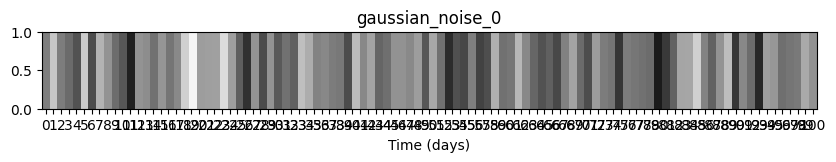

In [21]:

Es_norm=load_environments(str_E, envPath, num_days, iEs)

# Plot the environments
for indx_E, E in zip(iEs, Es_norm):
    lbl_E = f'{str_E}_{indx_E}'
    plot_environment(E, 1, lbl_E)


## Computer simulations: Serial transfers (Multiple Es)

In [22]:


def simulate_environment_multistrain(model_params, istrains, E):
    """
    Simulates the bacterial dynamics for multiple strains in a specific environmental condition.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    istrains: list
        A list of the strains that should be included in the simulation.
    E: array
        The environmental data for the simulation.

    Returns:
    Btot: array
        The total bacterial density at the end of the simulation.
    BpE, BpK: arrays
        The densities of plasmid-bearing strains with and without the resistance gene, respectively.
    BfE, BfK: arrays
        The densities of plasmid-free strains with and without the resistance gene, respectively.
    freqpE, freqpK: arrays
        The frequencies of plasmid-bearing strains with and without the resistance gene, respectively.
    times_list, ys_list: lists
        The time points and corresponding solution vectors at which the solution was evaluated.
    strains_params_list: list
        A list of the strain-specific parameters for each of the strains included in the simulation.
    """
    print('.', end="", flush=True)

    # Simulate transfers for the given strains and environment
    times_list, ys_list, strains_params_list = simulateTransfers_multistrain(model_params, istrains, E, type_experiment)

    # Extract the final time point and corresponding solution vectors
    final_times, final_ys = get_final_points(times_list, ys_list)

    # Analyze the simulation results to get bacterial densities and frequencies
    Btot, BpE, BpK, BfE, BfK, freqpE, freqpK  = analyze_simulation(model_params, istrains, final_ys)

    return Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, times_list, ys_list, strains_params_list

def simulate_environments_multistrain(model_params, istrains, Es):
    """
    Simulates the bacterial dynamics for multiple strains across different environments.

    This function iterates over the given environments, simulating the dynamics of the bacterial strains
    in each environment and collecting the results.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    istrains: list
        A list of the strains that should be included in the simulation.
    Es: list of arrays
        A list of environmental data for the simulation, each array corresponds to a different environment.

    Returns:
    Btots: list of arrays
        The total bacterial density at the end of each simulation.
    BpEs, BpKs: lists of arrays
        Lists of the densities of plasmid-bearing strains with and without the resistance gene, respectively.
    BfEs, BfKs: lists of arrays
        Lists of the densities of plasmid-free strains with and without the resistance gene, respectively.
    freqpEs, freqpKs: lists of arrays
        Lists of the frequencies of plasmid-bearing strains with and without the resistance gene, respectively.
    ts: list of lists
        Lists of the time points at which the solution was evaluated in each simulation.
    ys: list of lists
        Lists of the corresponding solution vectors for each time point in each simulation.
    params: list of lists
        Lists of the strain-specific parameters for each of the strains included in the simulation.
    """
    freqpEs = []
    freqpKs = []
    BpEs=[]
    BpKs=[]
    BfEs=[]
    BfKs=[]
    Btots=[]
    ts=[]
    ys=[]
    params=[]
    for E in Es:
        Btot, BpE, BpK, BfE, BfK, freqpE, freqpK, times_list, ys_list, params_list = simulate_environment_multistrain(model_params, istrains, E)
        freqpEs.append(freqpE)
        freqpKs.append(freqpK)
        BfEs.append(BfE)
        BfKs.append(BfK)
        BpEs.append(BpE)
        BpKs.append(BpK)
        Btots.append(Btot)
        ts.append(times_list)
        ys.append(ys_list)
        params.append(params_list)

    return Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params



In [23]:
def get_sequences_from_files(directory, length=None):
    """
    Extracts sequences of integers from the names of the files in a directory.

    This function looks for files with names that start with "sim_Es_" and end with ".pkl", then
    extracts a sequence of integers from the rest of the filename. It assumes that the integers
    are separated by underscores.

    Parameters:
    directory: str
        The path to the directory containing the files.
    length: int, optional
        The length of the sequences to look for. If specified, only sequences of this length are returned.
        If not specified, sequences of any length are returned.

    Returns:
    sequences: list of lists
        A list of the sequences that were found. Each sequence is represented as a list of integers.
    """
    sequences = []

    for filename in os.listdir(directory):
        if filename.startswith("sim_Es_") and filename.endswith(".pkl"):
            sequence = filename[len("sim_Es_"):-len(".pkl")]
            sequence = list(map(int, sequence.split('_')))

            if length is None or len(sequence) == length:
                sequences.append(sequence)

    return sequences


## Parallel computer simulations: Serial transfers (Multiple Es, Multiple strains)

In [24]:

def simulate_subset(model_params, istrains=[], Es=[]):
    """
    Simulates multiple bacterial strain growth for subsets of strains in varying environments.

    This function simulates bacterial growth for subsets of the given strains in the provided
    environments. It outputs the total bacterial biomass, plasmid-bearing and plasmid-free biomass
    for both environment types, and the frequency of plasmid-bearing bacteria for both environment types.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    istrains: list, optional
        List of strain indexes to be simulated.
    Es: list, optional
        List of environments for the simulation.

    Returns:
    istrains_all, Es_all, Btots_all, BpEs_all, BpKs_all, BfEs_all, BfKs_all, freqpEs_all, freqpKs_all, ts_all, ys_all, params_all:
        Lists containing, respectively, all strain subsets, all environments, total bacterial biomass, plasmid-bearing
        biomass for both environments, plasmid-free biomass for both environments, frequency of plasmid-bearing
        bacteria for both environments, simulation times, system state for each time step, and model parameters.
    """
    freqpEs_all=[]
    freqpKs_all=[]
    Btots_all=[]
    BpEs_all=[]
    BpKs_all=[]
    BfEs_all=[]
    BfKs_all=[]
    istrains_all=[]
    Es_all=[]
    ys_all=[]
    ts_all=[]
    params_all=[]


    for subset_length in range(1, len(istrains) + 1):
      freqpEs = []
      freqpKs = []
      Btots=[]
      BpEs=[]
      BpKs=[]
      BfEs=[]
      BfKs=[]
      ys=[]
      ts=[]
      params=[]

      subset = istrains[:subset_length]
      print(f"\t{subset}: ", end="", flush=True)

      str_subset = [str(x) for x in subset]  # Convert all elements to string
      sim_lbl = "_".join(str_subset)  # Join elements with "_"
      fileName = "sim_Es_%s.pkl" % sim_lbl  # Construct the filename

      if os.path.isfile("%s%s"%(runPath, fileName)):

        istrains_subset, Es, Btot, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params = load_simulation_results("%s%s"%(runPath, fileName))
        print(" Loading %s%s"%(runPath, fileName))
      else:

        # Iterate over each E in Es
        for E in Es:

              # Run the simulation for the current E and subset
              this_Btot, this_BpEs, this_BpKs, this_BfEs, this_BfKs, this_freqpEs, this_freqpKs, this_ts, this_ys, this_params = simulate_environment_multistrain(model_params, subset, E)
              Btots.append(this_Btot)
              BpEs.append(this_BpEs)
              BpKs.append(this_BpKs)
              BfEs.append(this_BfEs)
              BfKs.append(this_BfKs)
              freqpEs.append(this_freqpEs)
              freqpKs.append(this_freqpKs)
              ts.append(this_ts)
              ys.append(this_ys)
              params.append(this_params)

              if np.any(this_freqpEs+this_freqpKs)>0.5:
                print('*', end="", flush=True)
              else:
                print('o', end="", flush=True)

        save_simulation_results("%s%s"%(runPath, fileName), subset, Es, Btots, BpEs, BpKs, BfEs, BfKs, freqpEs, freqpKs, ts, ys, params)
        print(" Saving %s%s"%(runPath,fileName))

      istrains_all.append(subset)
      Btots_all.append(Btots)
      Es_all.append(Es)
      BpEs_all.append(BpEs)
      BpKs_all.append(BpKs)
      freqpEs_all.append(freqpEs)
      ts_all.append(ts)
      ys_all.append(ys)
      params_all.append(params)

    return istrains_all, Es_all, Btots_all, BpEs_all, BpKs_all, BfEs_all, BfKs_all, freqpEs_all, freqpKs_all, ts_all, ys_all, params_all


## Community combinatorics

In [25]:
def select_random_elements(strains_subset, num_elements):
    """
    Selects a specified number of random elements from a given list.

    This function randomly selects a specified number of elements from the provided list,
    without replacement. The function is primarily used for selecting a subset of bacterial strains.

    Parameters:
    strains_subset: list
        List from which elements are to be randomly selected.
    num_elements: int
        Number of elements to be randomly selected from the list.

    Returns:
    random_elements: list
        List of randomly selected elements.
    """

    random_elements = random.sample(strains_subset, num_elements)
    return random_elements


In [26]:


def run_experiment(model_params, strains_subset, num_expe, istrains_done):
    """
    Runs the entire simulation experiment for a given set of strains.

    This function performs a specified number of simulation experiments on a provided subset of strains.
    Each experiment runs a series of simulations using a set of strains chosen either from a list of
    already completed strains (if available) or randomly selected from the subset.

    Parameters:
    model_params: dict
        The dictionary containing model parameters.
    strains_subset: list
        List containing all potential strains that can be used in the simulation.
    num_expe: int
        Number of simulation experiments to be performed.
    istrains_done: list
        List of strain sets for which simulations have already been completed.

    Returns:
    Various lists of experiment results including total biomass, total plasmid-bearing and
    plasmid-free strains, total plasmid frequency, specific time points, states at those time
    points, and strain-specific parameters used.
    """

    max_strains = len(strains_subset)

    istrains_expe = []
    Es_expe = []
    Btots_expe = []
    BpEs_expe = []
    BpKs_expe = []
    BfEs_expe = []
    BfKs_expe = []
    freqpEs_expe = []
    freqpKs_expe = []
    ts_expe = []
    ys_expe = []
    params_expe = []

    for i in range(num_expe):
        start_time = time.time()  # Record the start time

        if i < len(istrains_done):
            istrains = istrains_done[i]
            print('* ', i, ': istrains =', istrains)
        else:
            istrains = select_random_elements(strains_subset, max_strains)
            print('** ', i, ': istrains =', istrains)

        # Run the simulations
        istrains_subset, Es_subset, Btots_subset, BpEs_subset, BpKs_subset, BfEs_subset, BfKs_subset, freqpEs_subset, freqpKs_subset, ts_subset, ys_subset, params_subset = simulate_subset(model_params, istrains, Es)

        istrains_expe.append(istrains_subset)
        Es_expe.append(Es_subset)
        Btots_expe.append(Btots_subset)
        BpEs_expe.append(BpEs_subset)
        BpKs_expe.append(BpKs_subset)
        BfEs_expe.append(BfEs_subset)
        BfKs_expe.append(BfKs_subset)
        freqpEs_expe.append(freqpEs_subset)
        freqpKs_expe.append(freqpKs_subset)
        ts_expe.append(ts_subset)
        ys_expe.append(ys_subset)
        params_expe.append(params_subset)

        end_time = time.time()  # Record the end time
        elapsed_time = end_time - start_time  # Calculate the elapsed time

        print("Total time elapsed: {:.2f} seconds".format(elapsed_time))

    return istrains_expe, Es_expe, Btots_expe, BpEs_expe, BpKs_expe, BfEs_expe, BfKs_expe, freqpEs_expe, freqpKs_expe, ts_expe, ys_expe, params_expe



In [27]:


for Amax in Amax_values:
  print("******** Amax=%s"%Amax)

  Es = [Amax * e for e in Es_norm]

  expeLabel='%s_N%s_A%se-2'%(str_E, num_days, int(Amax*100))
  runPath = path+'runs/'+expeLabel+'/'
  print("runPath=%s"%runPath)


  if not os.path.exists(runPath):
    os.makedirs(runPath)

  istrains_done = get_sequences_from_files(runPath, length=len(strains_subset))
  istrains_done = istrains_done[:num_expe]

  #istrains_expe, Es_expe, Btots_expe, BpEs_expe, BpKs_expe, BfEs_expe, BfKs_expe, freqpEs_expe, freqpKs_expe, ts_expe, ys_expe, params_expe = run_experiment(model_params, strains_subset, num_expe, istrains_done)


******** Amax=0.0625
runPath=./runs/gaussian_noise_N100_A6e-2/
******** Amax=0.125
runPath=./runs/gaussian_noise_N100_A12e-2/
******** Amax=0.25
runPath=./runs/gaussian_noise_N100_A25e-2/
******** Amax=0.5
runPath=./runs/gaussian_noise_N100_A50e-2/
******** Amax=1.0
runPath=./runs/gaussian_noise_N100_A100e-2/
******** Amax=2.0
runPath=./runs/gaussian_noise_N100_A200e-2/


In [28]:


def plot_freqps_expe(freqpEs_expe, freqpKs_expe):
    """
    Creates a scatter plot of the plasmid frequencies at the end of each simulation experiment.

    This function generates a plot of plasmid frequencies for multiple simulation experiments, each involving
    different combinations of bacterial strains. It applies jitter (random noise) to the x-coordinate of each
    point in order to improve readability when multiple data points share the same x-coordinate.

    Parameters:
    freqpEs_expe: list of lists
        Each inner list contains the plasmid frequencies of the E strain for each environment in a single experiment.
    freqpKs_expe: list of lists
        Each inner list contains the plasmid frequencies of the K strain for each environment in a single experiment.

    Returns:
    None
    """

    # Number of experiments
    num_expe = len(freqpEs_expe)

    fig, ax = plt.subplots(1, 1, figsize=(6,4))

    # Get the default color cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Define standard deviation for jitter
    jitter_sd = 0.1

    # Loop over each experiment
    for n in range(num_expe):

        num_subsets=len(freqpEs_expe[n])

        for s in range(num_subsets):

            num_members=len(istrains_expe[n][s])

            num_environments = len(freqpEs_expe[n][s])

            for e in range(num_environments):

                # Use color from cycle, looping back to the start if there are more experiments than colors
                color = color_cycle[n % len(color_cycle)]


                freqpEs=(freqpEs_expe[n][s][e])
                freqpKs=(freqpKs_expe[n][s][e])

                # Add jitter
                jitter = np.random.normal(scale=jitter_sd)

                ax.plot(num_members + jitter, freqpEs[-1], 'o', color=color, alpha=0.25)
                ax.plot(num_members + jitter, freqpKs[-1], '*', color=color, alpha=0.25)

    ax.set_xlabel('Number of strains')
    ax.set_ylabel('Plasmid frequency (%)')
    ax.set_ylim([-0.05,1.05])

    plt.show()


  #plot_freqps_expe(freqpEs_expe, freqpKs_expe)


